## Install and load the packages required for the analysis

In [107]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load(randomForest, vegan, cluster, factoextra)

Loading required package: pacman


## Load and inspect data

In [104]:
tab <- read.csv("XSectional MS2 feature table_proc_all_noMR_60_600s_top5000.csv", ,  check.names=FALSE, stringsAsFactors=F)
head(tab[,1:4])

Sample,clustid,200_496.3398_6.68Spectral Match to Lyso-PC(16:0) from NIST14,224_522.3555_6.84Spectral Match to 1-(9Z-Octadecenoyl)-sn-glycero-3-phosphocholine from NIST14
CF010_-355D_RA5_01_35268.mzXML,1,14199739,16504249
CF012_23D_RA1_01_35522.mzXML,1,2719587,2113370
CF034_-327D_RA9_01_35276.mzXML,2,10530896,3953290
CF034_51D_RH4_01_35446.mzXML,1,10085481,4490178
CF037_-196D_RD8_01_35352.mzXML,2,17742067,11103253
CF041_-222D_RC9_01_35328.mzXML,2,1384566,1184195


## Perform silhouette analysis

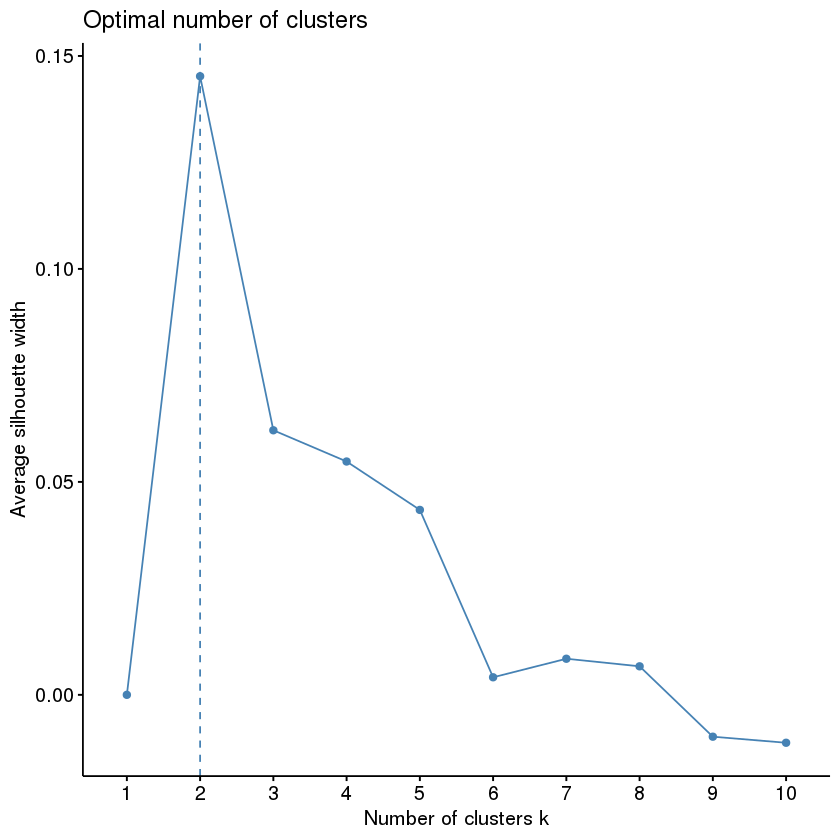

In [105]:
fviz_nbclust(tab[,-c(1:2)], hcut, method = "silhouette",
             hc_method = "ward.D", diss=vegdist(tab[,-c(1:2)], method='bray'))

## Perform jackknifed Emperor plots with confidence ellipsoids

### Save data in qiime format

In [25]:
# number of columns to exclude
ncolumn <- 2 

tab2 <- t(tab[,-c(1:ncolumn)])
feat_table <- data.frame(SampleID=1:nrow(tab2), tab2)
colnames(feat_table)[-1] <- gsub("_", ".", tab[,1])
colnames(feat_table)[1] <- '#SampleID'

if(ncolumn>1) {
            mapping <- data.frame(SampleID=gsub("_", ".", tab[,1]), BarcodeSequence="GATACA",   LinkerPrimerSequence="GATACA",  tab[,1:ncolumn][,-1],     Description="Metabolome")
            colnames(mapping) <- c("SampleID", "BarcodeSequence", "LinkerPrimerSequence",  colnames(tab)[1:ncolumn][-1], "Description")
} else{
            mapping <- data.frame(SampleID=gsub("_", ".", tab[,1]), BarcodeSequence="GATACA",   LinkerPrimerSequence="GATACA", Description="Metabolome")
}
 


write.table(matrix(c(paste0("#", colnames(mapping)[1]), colnames(mapping)[-1]), nrow=1), "mapping_file.txt", row.names = FALSE, col.names = FALSE, sep="\t", quote = FALSE)
write.table(mapping, "mapping_file.txt", row.names = FALSE, col.names = FALSE, sep="\t", append = TRUE, quote = FALSE)
write.table(feat_table, "feat_table.txt", row.names = FALSE, sep="\t", quote = FALSE)

### Run qiime script

In [ ]:
system('./qiime.sh', intern=TRUE)

## Random forest classification variable importance

In [91]:
# Format the data and save variable names
tab <- tab[,-1]
tab[,1] <- as.factor(tab[,1])
cnames <- colnames(tab)[-1]
colnames(tab)[-1] <- paste0('X', 1:(ncol(tab)-1))

In [92]:
# Fit classification model using the groups obtained by hierarchical clustering as labels
xsectional.rf <- randomForest(clustid ~ ., data=tab, importance=TRUE,
                        proximity=TRUE)

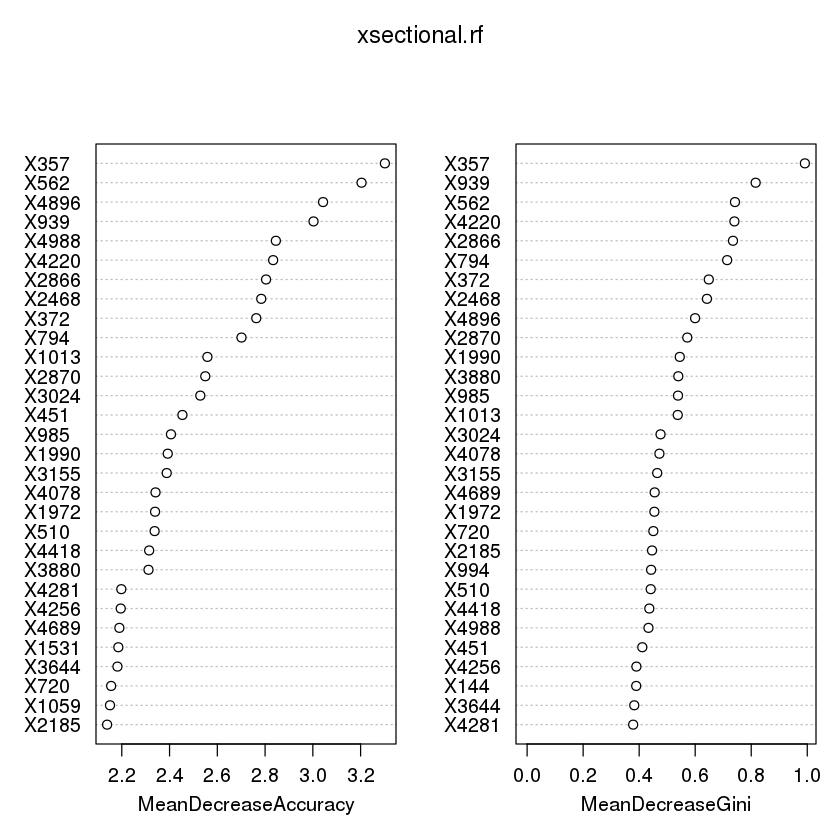

In [93]:
varImpPlot(xsectional.rf)

In [94]:
head(xsectional.rf$importance)

,1,2,MeanDecreaseAccuracy,MeanDecreaseGini
X1,0.00000,0,0e+00,0.000000000
X2,0.00000,0,0e+00,0.000000000
X3,0.00000,0,0e+00,0.000000000
X4,0.00025,0,1e-04,0.003920000
X5,0.00000,0,0e+00,0.000000000
X6,0.00000,0,0e+00,0.003929825


In [96]:
# create variable importance table and export
imp <- cbind(cnames, xsectional.rf$importance[, c('MeanDecreaseAccuracy', 'MeanDecreaseGini')])
colnames(imp)[1] <- 'Compound id'
imp <- imp[order(imp[,3], decreasing = TRUE),]
head(imp)

,Compound id,MeanDecreaseAccuracy,MeanDecreaseGini
X357,3638_487.3108_3.87NA,0.00945378075656713,0.991592372823024
X939,7910_506.2943_4.12NA,0.0070074893946303,0.815796633900991
X562,4994_507.2808_4.15NA,0.00894796740926772,0.74193701757056
X4220,5628_808.4183_3.27NA,0.00537561316740883,0.739971775312183
X2866,3877_826.9696_5.38NA,0.00655704534395163,0.734927622488419
X794,9027_507.2825_4.1NA,0.00628472387605514,0.714125715292235


In [97]:
write.table(imp, 'XSectional_RF_variable_importance.tsv', sep='\t', row.names = FALSE)